# Testing different Variations on the Variational Autoencoder



## Input info 

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])
raw_data = raw_data.loc[:, raw_data.columns != "timestamp"]
#make indices start at 0
raw_data["userId"] -= 1
raw_data["movieId"] -= 1
#make ratings center around 0
raw_data["rating"] -= 3

# create (943, 1682) matrix of user ratings per movie
user_ratings = pd.DataFrame(np.zeros((943,1682)))
for i in raw_data.index:
    user_ratings[raw_data["movieId"][i]][raw_data["userId"][i]] = raw_data["rating"][i]
user_ratings = user_ratings.to_numpy() 
np.random.shuffle(user_ratings)
user_ratings

C:\Users\leuch\AppData\Local\Temp\ipykernel_1076\2468113692.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])


array([[-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Begin model and tuning of Hyperparameters

In [2]:
from torch.utils.data import Dataset, DataLoader
from torch import nn 
import torch
from sklearn.metrics import precision_recall_fscore_support
device = "cuda"

class MovielensDataset(Dataset):
    def __init__(self, data, mask_magnitude):
        self.data = data
        # create a mask of 0 and 1 values where half are 0 and half are 1. 
        #The ratio of masked values is something that can and should be optimized. 
        self.random_mask = np.clip((np.random.randn(1682) + mask_magnitude).round(), a_max = 1, a_min = 0)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        np.random.shuffle(self.random_mask)
        return self.data[idx] * self.random_mask, self.data[idx]


def train(dataloader, model,  optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        #compute prediction error
        pred, z, mu, std = model(X)
        loss = model.vae_loss(pred, y, z, mu, std)
        mse_loss = mse_loss_fcn(pred, y)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0 and batch % 64 == 0:
            loss , current = loss.item(), (batch+1) * len(X)
            print("Epoch : " + str(epoch))
            print(f"loss: {loss:>7f}")
            print(f"MSE loss: {mse_loss:>7f}")
            losses.append(loss)
            mse_losses.append(mse_loss.item())

def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    num_batches= len(dataloader)
    model.eval()
    test_loss, correct, test_mse_loss = 0,0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            
            
            pred, z, mu, std = model(X)
            test_loss += model.vae_loss(pred, y, z, mu, std).item()
            test_mse_loss += mse_loss_fcn(pred, y)
    test_loss /= num_batches
    test_mse_loss /= num_batches
    if epoch % 100 ==0:
        test_losses.append(test_loss)
        #Come back and actually do the accuracy where it sees if it's at least on the right side of it or compute precision/recall or something like that
        print(f"Test Error: \n Avg Loss : {test_loss:>8f} ")
        print(f" Test MSE loss: {test_mse_loss:>7f}")
        test_mse_losses.append(test_mse_loss.item())
        model.test_mse = test_mse_loss.item()
        
        
        

## The actual search 
The following contains all of the logic you need to do to restart everything over so long as you've already loaded the ones above

In [23]:
from VAEMSE import VAEMSE

epochs = 2000
lowest_test_mse_score = 1000
mask_magnitude = 1.3
#Search 
l2_weight = 0
dropout_rate = 0
random_mask = np.clip((np.random.randn(1682) + mask_magnitude).round(), a_max = 1, a_min = 0)
print("using hyperparameters : " + str( l2_weight) + " , " + str(dropout_rate))
train_dataset = MovielensDataset(user_ratings[:843], mask_magnitude)
test_dataset = MovielensDataset(user_ratings[843:], mask_magnitude)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)


losses = []
mse_losses = []    
test_losses = []
test_mse_losses = []

model = VAEMSE(dropout_rate = dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = l2_weight)
mse_loss_fcn = nn.MSELoss()

for t in range(epochs):
    train(train_dataloader, model,  optimizer, t)
    test(test_dataloader, model, t )
    if t % 100 == 0:
        if model.test_mse < lowest_test_mse_score:
            lowest_test_mse_score = model.test_mse
            torch.save(model.state_dict(), "./models/best.pth")
            print("New best using hyper parameters : " + str(mask_magnitude) + " ," + str(l2_weight) + " ," + str(dropout_rate)  )

using hyperparameters : 0 , 0
Epoch : 0
loss: 3056.917480
MSE loss: 0.305685
Test Error: 
 Avg Loss : 959.255920 
 Test MSE loss: 0.095941
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 100
loss: 429.839600
MSE loss: 0.041802
Test Error: 
 Avg Loss : 688.990295 
 Test MSE loss: 0.067432
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 200
loss: 353.020966
MSE loss: 0.031716
Test Error: 
 Avg Loss : 688.052856 
 Test MSE loss: 0.064259
New best using hyper parameters : 1.3 ,0 ,0
Epoch : 300
loss: 244.977554
MSE loss: 0.019617
Test Error: 
 Avg Loss : 637.296814 
 Test MSE loss: 0.062721
New best using hyper parameters : 1.3 ,0 ,0


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)) * 100, losses)
plt.plot(np.arange(len(test_losses)) * 100, test_losses)

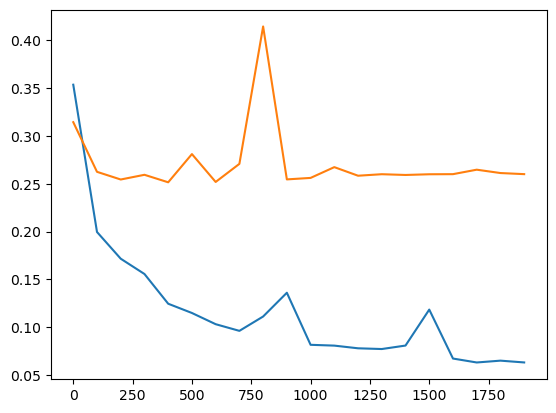

In [20]:
plt.plot(np.arange(len(mse_losses)) * 100, np.sqrt(np.array(mse_losses)))
plt.plot(np.arange(len(test_mse_losses)) * 100, np.sqrt(np.array(test_mse_losses)))

# Calculate Precision and Recall

In [21]:
model = VAEMSE(dropout_rate = 0).to(device)
model.load_state_dict(torch.load("./models/best.pth"))
model.eval()
relevance_labels = user_ratings[843:] > 0.5
#To evaluate for comparison to other papers we mask by setting 20% of labels to false 
test_inputs = np.clip((np.random.randn(1682) + 1.35).round(), a_max = 1, a_min = 0) * user_ratings[843:]
test_preds = model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0] > .4

precision_recall_fscore_support(relevance_labels.flatten(), test_preds.cpu().flatten(), average="binary")

(0.57855587808418, 0.6144508670520231, 0.5959633713324612, None)

# Calculate RMSE

In [22]:
nonzero_indices = torch.tensor(test_inputs).to("cuda").nonzero().split( 1, dim=1)
torch.sqrt(((torch.tensor(test_inputs).to("cuda")[nonzero_indices] - model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0][nonzero_indices]) ** 2).mean())

tensor(1.0015, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)

## Conclusion:
The result is that I was, in fact, mistaken and that the MSE was less suited to the task than the usual Gaussian Likelihood

In [ ]:
import matplotlib.pyplot as plt
plt.hist(model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0].cpu().detach().numpy().flatten(), bins = [-2.1, -1.9, -1.1, -0.9, -.1, 0, .1, .9, 1.1, 1.9, 2.1])

In [ ]:
plt.hist(test_inputs.flatten(), bins = [-2.1, -1.9, -1.1, -0.9, -.1, 0, .1, .9, 1.1, 1.9, 2.1])